In this notebook we explore the GTZAN dataset and build 3 second segments of each music file into a spectrogram.

<a href="https://colab.research.google.com/github/RamtinMoslemi/music-classification-with-spectrograms/blob/main/GTZAN_Three_Second_Generation.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Downloading and Installing the Dataset

In [1]:
# @title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import IPython.display as display
import librosa
import librosa.display

In [3]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

## Loading GTZAN dataset (includes spectrograms)

The GTZAN dataset for music genre classification can be dowloaded from [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification).

To download from Kaggle using this code you need to download and copy over your api token. In Kaggle go to the upper right side -> account -> API -> create API token. This downloads a json file. Copy the content into api_token. It should look like this:

api_token = {"username":"johnsmith","key":"123a123a123"}

In [4]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

# Exploring the Dataset

## Have a look at the data

In this section we are looking at an example of an audio waveform. Then we'll transform the sound wave to a spectrogram and compare it with the spectrogram that was included with the downloaded dataset.

In [7]:
# Inspect an audio file from the dataset.

sample_path = 'Data/genres_original/rock/rock.00054.wav'

# if you want to listen to the audio, uncomment below.
display.Audio(sample_path)

y: [-0.03817749 -0.01821899 -0.02246094 ...  0.00189209  0.00866699
  0.01657104] 

y shape: (661794,) 

Sample rate (KHz): 22050 

Length of audio: 30.013333333333332


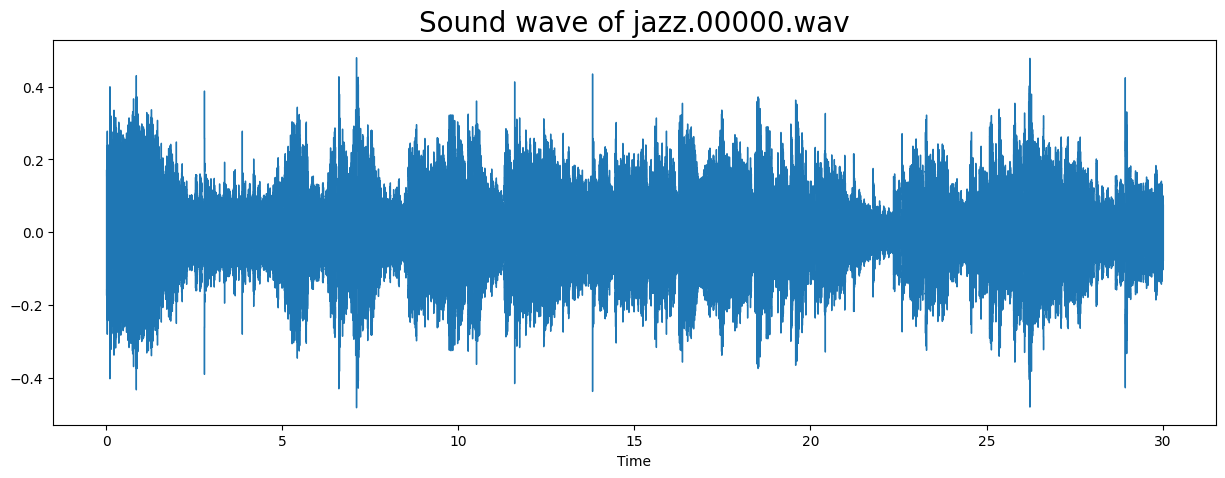

In [8]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (KHz):', sample_rate, '\n')
print(f'Length of audio: {np.shape(y)[0]/sample_rate}')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

The mel spectrogram uses mel sclae intead of a linear one: [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments.

Shape of D object: (1025, 1293)


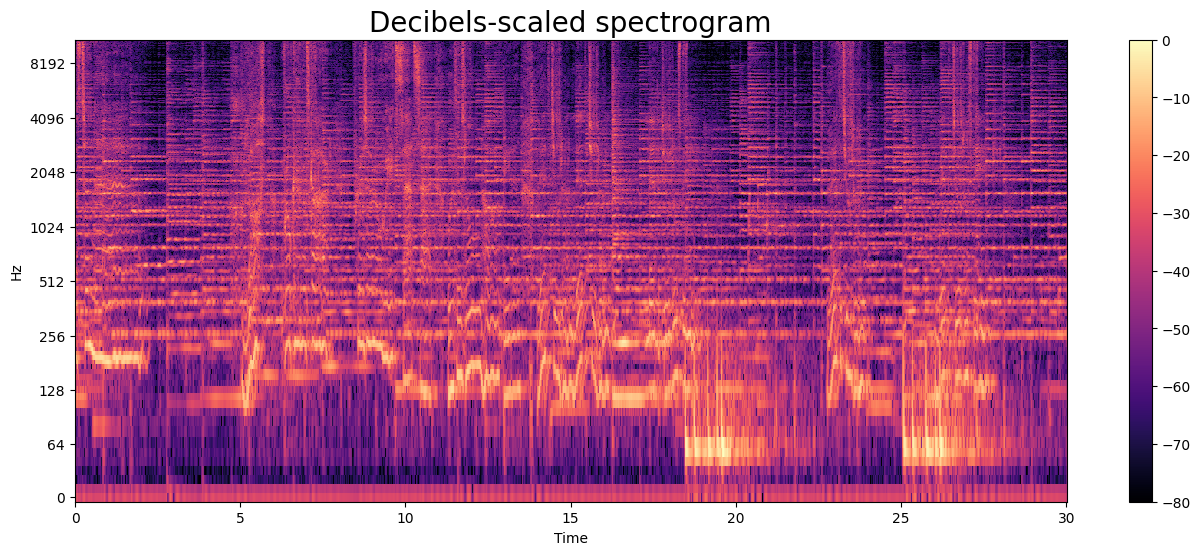

In [9]:
# Convert sound wave to spectrogram.

# Short-time Fourier transform (STFT).

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

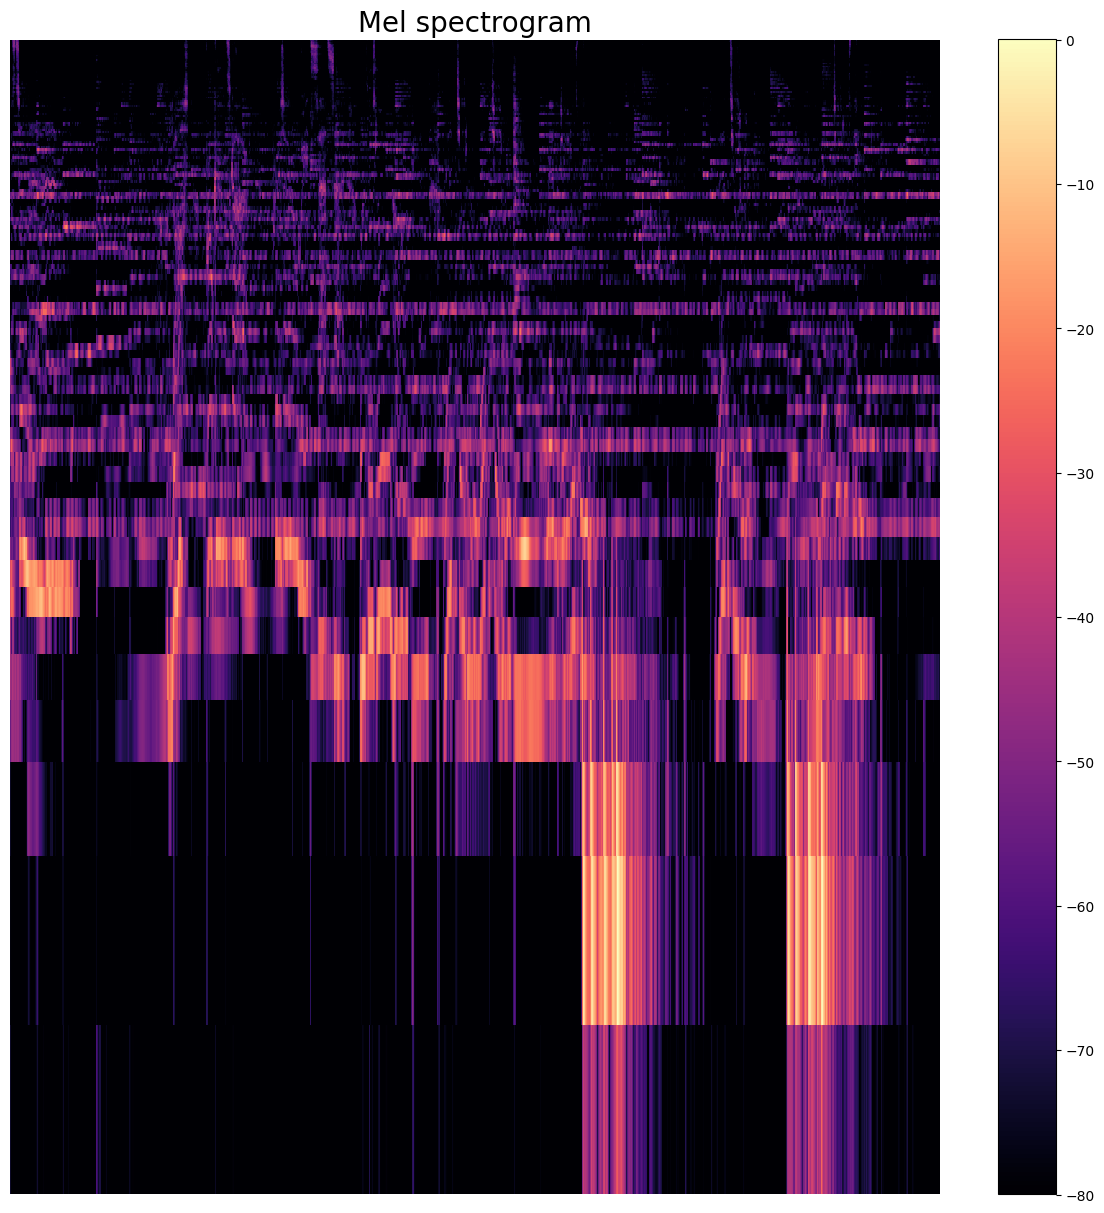

In [10]:
# Convert sound wave to mel spectrogram.

y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15, 15))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.axis(False)
plt.show()

In [11]:
window_size = 1024
window = np.hanning(window_size)
stft  = librosa.core.spectrum.stft(y[:len(y)//10], n_fft=window_size, hop_length=512, window=window)
out = 2 * np.abs(stft) / np.sum(window)

fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax)
fig.savefig('spec.png',transparent="True", pad_inches=0)

<ipython-input-12-336fea512865>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


(288, 432, 4)


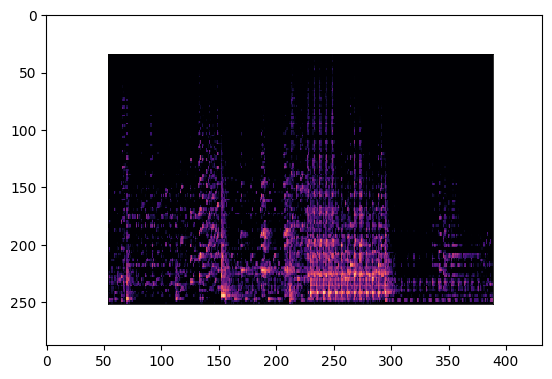

In [12]:
# Visualize the mel spectrogram of the same sample from the dataset.

img_path = 'Data/images_original/jazz/jazz00000.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()

# Building the 3 second dataset

In [ ]:
def make_spectrograms(path, genre, num=10, mel=False):
  y, sr = librosa.load(path)
  _, id, _ = path.split('.')
  size = len(y)//num
  window_size = 1024
  window = np.hanning(window_size)
  for i in range(num):
    if mel:
      S = librosa.feature.melspectrogram(y=y[i * size:(i+1) * size], sr=sr)
      # save
      fig = plt.Figure()
      canvas = FigureCanvas(fig)
      ax = fig.add_subplot(111)
      p = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), ax=ax)
      fig.savefig("Data/3sec/mel/" + genre + '/' + genre + "." + str(id) + str(i) + '.png',transparent="True", pad_inches=0)
    else:
      stft  = librosa.core.spectrum.stft(y[i * size:(i+1) * size],
                              n_fft=window_size, hop_length=512, window=window)
      out = 2 * np.abs(stft) / np.sum(window)
      # save
      fig = plt.Figure()
      canvas = FigureCanvas(fig)
      ax = fig.add_subplot(111)
      p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax)
      fig.savefig("Data/3sec/decibel/" + genre + '/' + genre + "." + str(id) + str(i) + '.png',transparent="True", pad_inches=0)

In [ ]:
def see_progress(mel=False):
  music_dir = "Data/genres_original/"
  genres = list(os.listdir(music_dir))
  if mel:
    folder_names = ['Data/3sec/mel/' + genre for genre in genres]
  else:
    folder_names = ['Data/3sec/decibel/' + genre for genre in genres]
  not_done = []
  for folder in folder_names:
    l = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])
    print(folder, l)
    if l != 1000:
      d, s, t, g = folder.split('/')
      not_done.append(g)
  return not_done
see_progress(mel=True)

In [ ]:
def make_dir(mel=False):
  music_dir = "Data/genres_original/"
  genres = list(os.listdir(music_dir))
  path = 'Data/3sec/mel/' if mel else 'Data/3sec/decibel/'
  # make main dir
  if os.path.exists(path):
    shutil.rmtree(path)
    os.mkdir(path)
  else:
    os.mkdir(path)
  # make genre dir
  folder_names = [path + genre for genre in genres]
  for f in folder_names:
    if os.path.exists(f):
      shutil.rmtree(f)
      os.mkdir(f)
    else:
      os.mkdir(f)

def make_3sec_dataset(mel=False):
  make_dir(mel)
  # Loop over all genres.
  for g in see_progress(mel=mel):
    src_file_paths= []
    for path in glob.glob(os.path.join(music_dir, f'{g}',"*.wav"), recursive=True):
      try:
        make_spectrograms(path, genre=g, mel=mel)
      except:
        print('fail', path)
    print(g, 'is done')


music_dir = "Data/genres_original/"
genres = list(os.listdir(music_dir))
# create 3 second dataset
make_3sec_dataset()